In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import pygad.torchga

In [81]:
global a1, a2, x_train, y_train, k1, t_i,T_i,x_l,left_temp, null
def fitness_func(ga_instance, solution, sol_idx):
    
    model.weight = nn.Parameter( torch.FloatTensor( solution[0:a1] ) )
    model.weight = nn.Parameter( torch.FloatTensor( solution[a1:a2] ) )

    T = model( torch.cat((x_train, y_train),1) )
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    dTdy = torch.autograd.grad(T, y_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dy2 = torch.autograd.grad(dTdy, y_train, grad_outputs=torch.ones_like(dTdy), create_graph=True)[0]
    
    bc2 = torch.sum(torch.square(torch.mul(torch.mul( torch.where(x_train!=x_l,1,0), torch.where(y_train == y_t,1,0)),(T - 0)) ) ) /N_x
    bc3 = torch.sum(torch.square(torch.mul(torch.mul( torch.where(x_train!=x_l,1,0), torch.where(y_train == y_b,1,0)),(T - 0)) ) ) /N_x
    bc1 = torch.sum(torch.square(torch.mul( torch.where(x_train == x_l,1,0),(T - left_temp) ) ) )/N_x
    bc4 = torch.sum(torch.square(torch.mul( torch.where(x_train == x_r,1,0),(T - 0) ) ) )/N_x
    eq = mse( (dT2dy2+dT2dx2), null)
    loss = bc1 + bc2 + bc3 + eq + bc4
    abs_error = loss.detach().numpy() + 0.00000001

    solution_fitness = 1.0 / abs_error

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

def get_loss(x_train, y_train, model, T_i, left_temp, k1, x_l):

    mse = nn.MSELoss()
    T = model( torch.cat((x_train, y_train),1) )
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    dTdy = torch.autograd.grad(T, y_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dy2 = torch.autograd.grad(dTdy, y_train, grad_outputs=torch.ones_like(dTdy), create_graph=True)[0]
    
    bc2 = torch.sum(torch.square(torch.mul(torch.mul( torch.where(x_train!=x_l,1,0), torch.where(y_train == y_t,1,0)),(T - 0)) ) ) /N_x
    bc3 = torch.sum(torch.square(torch.mul(torch.mul( torch.where(x_train!=x_l,1,0), torch.where(y_train == y_b,1,0)),(T - 0)) ) ) /N_x
    bc1 = torch.sum(torch.square(torch.mul( torch.where(x_train == x_l,1,0),(T - left_temp) ) ) )/N_x
    bc4 = torch.sum(torch.square(torch.mul( torch.where(x_train == x_r,1,0),(T - 0) ) ) )/N_x
    eq = mse( torch.mul((dT2dy2+dT2dx2), torch.where(x_train!=x_l,1,0)), null)
    loss = bc1 + bc2 + bc3 + eq + bc4
    
    return loss, eq, bc1, bc2, bc3, bc4
    
# Create the PyTorch model.
layers = [2, 5, 5, 1]
model = torch.nn.Sequential(torch.nn.Linear(layers[0], layers[1]), nn.Tanh(),
                            torch.nn.Linear(layers[1], layers[2]), nn.Tanh(),
                            torch.nn.Linear(layers[2], layers[3]))
print(model)
a1 = sum(p.numel() for p in model.parameters() if p.requires_grad)
a2 = a1 + sum(p.numel() for p in model.parameters() if p.requires_grad and len(p.shape) == 1)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
num_solutions = 30
torch_ga = pygad.torchga.TorchGA(model=model, num_solutions = num_solutions)
mse = nn.MSELoss()

# Boundary Conditions 
left_temp = 1
right_temp = 0
x_l = 0
x_r = 0.5
y_t = 0.5
y_b = 0
N_x = 100
t_i = 0
t_f = 1
T_i = 0

# Parameters of the equation
k1 = 0.05

# Setup training and test dataset
x_train = np.linspace(x_l, x_r, N_x)
x_train = np.tile(x_train, N_x)
y_train = np.linspace(y_b, y_t, N_x)
y_train = np.repeat(y_train, N_x)

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)   
null = torch.zeros(N_x*N_x)
x_train = x_train.unsqueeze(-1)
y_train = y_train.unsqueeze(-1)
x_train = x_train.clone().detach().requires_grad_(True)
y_train = y_train.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 50 
num_parents_mating = 25
mutation_percent_genes = 50 
keep_parents = -1 

optimiser = torch.optim.AdamW([*model.parameters()], lr=9e-5)

mu, sigma = 0, 1 # mean and standard deviation
ini_pop = np.zeros((int(math.sqrt(num_solutions))**2, a2))
mu_arr = np.linspace(-0.25, 0.25, int(math.sqrt(num_solutions)) )
sigma_arr = np.linspace(0.1, 0.3, int(math.sqrt(num_solutions)) )
cnt = 0
for mu in mu_arr:
    for sigma in sigma_arr:
        tp = np.random.normal( mu,  sigma, (a2) ) 
        ini_pop[cnt] = tp
        cnt = cnt + 1
# ini_pop = np.random.rand(num_solutions, a2)

for i in range(10):
    
    print("i = ",i)
    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           initial_population=ini_pop,
                           fitness_func=fitness_func,
                           mutation_percent_genes=mutation_percent_genes,
                           parent_selection_type='tournament',
                           keep_parents = 5,
                           crossover_type = "two_points",
                           on_generation=callback_generation,
                           mutation_type = "random",
                           save_solutions=True)

    ga_instance.run()
    ini_pop = []
    solutions_arr = ga_instance.solutions[-num_solutions:]
    
    for solution in solutions_arr:
        print('start')
#         print(solution)
        
        wts = []
        bia = []
        cnt = 0
        
        ########### GA soln to pytorch input ############
        for ind in range(len(layers)-1):
            # Wts
            for j in range(layers[ind+1]):
                for k in range(layers[ind]):
                    wts.append(solution[cnt])
                    cnt = cnt+1

            # Biases
            for j in range(layers[ind+1]):
                bia.append(solution[cnt])
                cnt = cnt+1
                
        model.weight = nn.Parameter(torch.FloatTensor(wts))
        model.bias = nn.Parameter(torch.FloatTensor(bia))
        
        ########## Adam's Optimizer #################
        for epoch in range(1001):
            loss, eq, bc1, bc2, bc3, bc4 = get_loss(x_train, y_train, model, T_i, left_temp, k1, x_l)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            if epoch%500==0:
                print("Loss = ",loss.detach().numpy(),"epoch = ", epoch)
                print("bc1 = ",bc1.detach().numpy(),"epoch = ", epoch)
                print("bc2 = ",bc2.detach().numpy(),"epoch = ", epoch)
                print("bc3 = ",bc3.detach().numpy(),"epoch = ", epoch)
                print("bc4 = ",bc4.detach().numpy(),"epoch = ", epoch)

        ########## pytorch input to GA soln ###########
        
        w1 = list(model.parameters())
        wts = []
        bia = []
        for ind in range( 2, 2*(len(layers)-1)+2 ):
            a = w1[ind].detach().numpy()
            if ind%2==0:
                for j in range( a.shape[0]):
                    for k in range(a[0].shape[0]):
                        wts.append( a[j][k] )
            else:
                for j in range(a.shape[0]):
                    bia.append( a[j] )
                             
        ini_pop.append( wts+bia )
        print('end')

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution",solution_idx)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): Tanh()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
i =  0
Generation = 1
Fitness    = 0.3398368938198656
Generation = 2
Fitness    = 0.3398368938198656
Generation = 3
Fitness    = 0.3398368938198656
Generation = 4
Fitness    = 0.3398368938198656
Generation = 5
Fitness    = 0.3398368938198656
Generation = 6
Fitness    = 0.3398368938198656
Generation = 7
Fitness    = 0.3398368938198656
Generation = 8
Fitness    = 0.3398368938198656
Generation = 9
Fitness    = 0.3398368938198656
Generation = 10
Fitness    = 0.3398368938198656
Generation = 11
Fitness    = 0.3398368938198656
Generation = 12
Fitness    = 0.3398368938198656
Generation = 13
Fitness    = 0.3398368938198656
Generation = 14
Fitness    = 0.3398368938198656
Generation = 15
Fitness    = 0.3398368938198656
Generation = 16
Fitness    = 0.3398368938198656
Generation = 17
Fitness 

KeyboardInterrupt: 

In [31]:
a2

62

In [79]:
ini_pop = []
ini_pop = np.zeros((int(math.sqrt(num_solutions))**2, a2))
mu_arr = np.linspace(-0.25, 0.25, int(math.sqrt(num_solutions)) )
sigma_arr = np.linspace(0.1, 0.3, int(math.sqrt(num_solutions)) )
cnt = 0
for mu in mu_arr:
    for sigma in sigma_arr:
        tp = np.random.normal( mu,  sigma, (a2) ) 
        ini_pop[cnt] = tp
        cnt = cnt + 1
#             ini_pop.append( np.random.normal( mu,  sigma, (a2)) )
        


In [80]:
ini_pop

array([[-0.26239506, -0.34495169, -0.24803036, ..., -0.2621705 ,
        -0.27564407, -0.38932038],
       [-0.06040547, -0.27495873, -0.33876741, ..., -0.21154426,
        -0.20517609, -0.04007285],
       [ 0.07247503, -0.19795931, -0.38331672, ..., -0.28819375,
        -0.11573809,  0.17302489],
       ...,
       [ 0.24904536, -0.33460156,  0.17030047, ...,  0.51865016,
         0.25948899,  0.36601263],
       [ 0.37777676, -0.42001081,  0.59722826, ...,  0.49145203,
        -0.08930597,  0.00064207],
       [ 0.30402902, -0.08712649,  0.05484384, ...,  0.18137942,
         0.62621574, -0.08218534]])

In [78]:
ini_pop.shape

(5, 62)

In [50]:
len(ini_pop)

25

In [51]:
ini_pop

[array([-0.21178248, -0.14656078, -0.04466692, -0.27608495, -0.32886004,
        -0.39070765, -0.25883205, -0.28364461, -0.29194855, -0.05456172,
        -0.27627182, -0.2753978 , -0.20667015, -0.03388266, -0.30448536,
        -0.23530104, -0.11259273, -0.229169  , -0.24572204, -0.33321287,
        -0.19364824, -0.42230506, -0.30223279, -0.23547492, -0.23563463,
        -0.23484972, -0.20414321, -0.14146879, -0.47793554, -0.12931079,
        -0.16042396, -0.46144915, -0.35634844, -0.45424139, -0.25680834,
        -0.19387107, -0.25805549, -0.25052209, -0.43286156, -0.21130585,
        -0.33361896, -0.07146177, -0.36741537, -0.29778877, -0.20570237,
        -0.28257485, -0.19819109, -0.1320781 , -0.1456604 , -0.23383312,
        -0.10652029, -0.17539028, -0.49265213, -0.61714188, -0.17167433,
        -0.18915688, -0.34906838, -0.43401727, -0.34699261, -0.26668008,
        -0.19024061, -0.14955344]),
 array([-0.33514055, -0.44053215, -0.24832891, -0.25761598, -0.04771575,
        -0.4900

In [39]:
ini_pop = np.random.rand(num_solutions, a2)
ini_pop

array([[0.39490632, 0.81545106, 0.24271605, ..., 0.73749641, 0.88296184,
        0.34587462],
       [0.27734381, 0.10557234, 0.34606221, ..., 0.6217206 , 0.33874803,
        0.3057721 ],
       [0.79734746, 0.48024899, 0.5791719 , ..., 0.59913057, 0.85147967,
        0.71961133],
       ...,
       [0.63163804, 0.98402129, 0.47849152, ..., 0.59296028, 0.18099668,
        0.98580471],
       [0.48822603, 0.26649529, 0.97412382, ..., 0.03758339, 0.28458247,
        0.2496809 ],
       [0.55016099, 0.42285093, 0.97525184, ..., 0.19615607, 0.45094227,
        0.0686691 ]])

In [38]:
len(ga_instance.solutions)

180

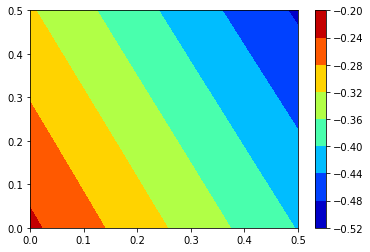

In [16]:
X = np.reshape(x_train.detach().numpy(), (N_x, N_x))
Y = np.reshape(y_train.detach().numpy(), (N_x, N_x))
T = model( torch.cat((x_train, y_train),1) )
T = np.reshape(T.detach().numpy(), (N_x, N_x))
plt.contourf( X,Y,T, cmap = plt.cm.jet)
plt.colorbar()

In [ ]:
len(solutions_arr)

In [ ]:
total_weights = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_biases = sum(p.numel() for p in model.parameters() if p.requires_grad and len(p.shape) == 1)

In [ ]:
total_biases

In [ ]:
# layers = [2, 5, 5, 1]
# model = torch.nn.Sequential(torch.nn.Linear(layers[0], layers[1]), nn.Tanh(),
#                             torch.nn.Linear(layers[1], layers[2]), nn.Tanh(),
#                             torch.nn.Linear(layers[2], layers[3]))
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print("Total trainable parameters in the model:", total_trainable_params)

In [18]:
global a1, a2, x_train, t_train, k1, t_i,T_i,x_l,left_temp, null
def fitness_func(ga_instance, solution, sol_idx):
    
    model.weight = nn.Parameter( torch.FloatTensor( solution[0:a1] ) )
    model.weight = nn.Parameter( torch.FloatTensor( solution[a1:a2] ) )

    T = model( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    
    ic = mse(torch.mul(torch.where(t_train == t_i,1,0),(T - T_i) ), null )  
    bc = mse(torch.mul( torch.where(x_train == 0,1,0),(T - left_temp) ), null ) 
    eq = mse( (dTdt-k1*dT2dx2), null)
    loss = ic + bc + eq
    abs_error = loss.detach().numpy() + 0.00000001

    solution_fitness = 1.0 / abs_error

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

def get_loss(x_train, t_train, model, T_i, left_temp, k1, x_l):

    mse = nn.MSELoss()
    T = model( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    
    ic = mse(torch.mul(torch.where(t_train == t_i,1,0),(T - T_i) ), null )  
    bc = mse(torch.mul( torch.where(x_train == 0,1,0),(T - left_temp) ), null ) 
    eq = mse( (dTdt-k1*dT2dx2), null)
    loss = ic + bc + eq
    
    return loss, eq, ic, bc
    
# Create the PyTorch model.
model = torch.nn.Sequential(torch.nn.Linear(2, 3), nn.Tanh(),
                            torch.nn.Linear(3, 3), nn.Tanh(),
                            torch.nn.Linear(3, 1))
print(model)
layers = [2, 3, 3, 1]
a1 = 18
a2 = 25
# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
num_solutions = 30
torch_ga = pygad.torchga.TorchGA(model=model, num_solutions = num_solutions)
mse = nn.MSELoss()

# Boundary Conditions 
left_temp = 0.6
right_temp = 0
x_l = 0
x_r = 0.7
N_x = 35
t_i = 0
t_f = 1
N_t = 35
T_i = 0

# Parameters of the equation
k1 = 0.05
k2 = 0.8

# Setup training and test dataset
x_train = np.linspace(0, x_r, N_x)
x_train = np.tile(x_train, N_t)
t_train = np.linspace(t_i, t_f, N_t)
t_train = np.repeat(t_train, N_x)

x_train = torch.FloatTensor(x_train)
t_train = torch.FloatTensor(t_train)   
null = torch.zeros(N_x*N_t)
x_train = x_train.unsqueeze(-1)
t_train = t_train.unsqueeze(-1)
x_train = x_train.clone().detach().requires_grad_(True)
t_train = t_train.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 50 
num_parents_mating = 3 
mutation_percent_genes = 75 
keep_parents = -1 

optimiser = torch.optim.Adam([*model.parameters()], lr=1e-4)

mu, sigma = 0, 0.5 # mean and standard deviation
ini_pop = np.random.normal(mu, sigma, (num_solutions, a2))

for i in range(10):
    
    print("i = ",i)
    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           initial_population=ini_pop,
                           fitness_func=fitness_func,
                           mutation_percent_genes=mutation_percent_genes,
                           keep_parents = -1,
                           on_generation=callback_generation,
                           save_solutions=True)

    ga_instance.run()
    ini_pop = []
    
    solutions_arr = ga_instance.solutions[-num_solutions:]
    
    for solution in solutions_arr:
        print('start')
#         print(solution)
        
        wts = []
        bia = []
        cnt = 0
        
        ########### GA soln to pytorch input ############
        for ind in range(len(layers)-1):
            # Wts
            for j in range(layers[ind+1]):
                for k in range(layers[ind]):
                    wts.append(solution[cnt])
                    cnt = cnt+1

            # Biases
            for j in range(layers[ind+1]):
                bia.append(solution[cnt])
                cnt = cnt+1
                
        model.weight = nn.Parameter(torch.FloatTensor(wts))
        model.bias = nn.Parameter(torch.FloatTensor(bia))
        
        ########## Adam's Optimizer #################
        for epoch in range(2001):
            loss, eq, ic, bc = get_loss(x_train, t_train, model, T_i, left_temp, k1, x_l)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            if epoch%2000==0:
                print("Loss = ",loss.detach().numpy(),"epoch = ", epoch)

        ########## pytorch input to GA soln ###########
        
        w1 = list(model.parameters())
        wts = []
        bia = []
        for ind in range( 2, 2*(len(layers)-1)+2 ):
            a = w1[ind].detach().numpy()
            if ind%2==0:
                for j in range( a.shape[0]):
                    for k in range(a[0].shape[0]):
                        wts.append( a[j][k] )
            else:
                for j in range(a.shape[0]):
                    bia.append( a[j] )
                             
        ini_pop.append( wts+bia )
        print('end')
#         print(ini_pop)
#     print("ini_pop = ",ini_pop)
    
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution",solution_idx)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Tanh()
  (4): Linear(in_features=3, out_features=1, bias=True)
)
i =  0
Generation = 1
Fitness    = 78.74715313972078
Generation = 2
Fitness    = 78.74715313972078
Generation = 3
Fitness    = 78.74715313972078
Generation = 4
Fitness    = 78.74715313972078
Generation = 5
Fitness    = 78.74715313972078
Generation = 6
Fitness    = 78.74715313972078
Generation = 7
Fitness    = 78.74715313972078
Generation = 8
Fitness    = 78.74715313972078
Generation = 9
Fitness    = 78.74715313972078
Generation = 10
Fitness    = 78.74715313972078
Generation = 11
Fitness    = 78.74715313972078
Generation = 12
Fitness    = 78.74715313972078
Generation = 13
Fitness    = 78.74715313972078
Generation = 14
Fitness    = 78.74715313972078
Generation = 15
Fitness    = 78.74715313972078
Generation = 16
Fitness    = 78.74715313972078
Generation = 17
Fitness    = 78.74715313

KeyboardInterrupt: 

In [ ]:
cnt

In [ ]:
len(solution)

In [ ]:
# solution
cnt = 0
for ind in range(len(layers)-1):
    # Wts
    for j in range(layers[ind+1]):
        for k in range(layers[ind]):
            wts.append(solution[cnt])
            cnt = cnt+1

    # Biases
    for j in range(layers[ind+1]):
        bia.append(solution[cnt])
        cnt = cnt+1

model.weight = nn.Parameter(torch.FloatTensor(wts))
model.bias = nn.Parameter(torch.FloatTensor(bia))

In [ ]:
N_test = 2000

t_pred = 0.1
x_test = torch.linspace(0.7,x_l,N_test)
t_test = torch.ones(N_test)*t_pred
x_test = x_test.unsqueeze(-1)
t_test = t_test.unsqueeze(-1)

y_pred = model( torch.cat((x_test, t_test),1) )
y_pred = y_pred.detach().numpy()
x_test = x_test.detach().numpy()
plt.plot(x_test, y_pred)

In [66]:
ini_pop

[array([[ 0.05226119, -1.05835405,  1.14158744,  0.38232005, -1.29480058,
         -0.64135169,  0.70298208,  1.12491071, -0.37113815, -0.21867017,
          1.28705788, -0.67605021,  0.61428056, -0.36337386,  0.21745953,
          1.12194393,  0.2749746 , -0.28691625, -0.23790774,  0.85674831,
          0.42732948,  1.4431016 , -0.38337508,  0.4387638 ,  0.63989001,
          0.35944362,  0.0493895 ,  0.86920962, -0.00744268,  0.54673975]]),
 array([[-0.1056891 , -0.39243178, -0.8486504 ,  0.79780561, -0.51482154,
          0.48491279, -0.39971426, -0.32767997, -0.34940205,  0.45980314,
         -0.6060627 , -0.3545264 ,  0.02672211, -0.98665444, -0.74099404,
          0.85079741,  0.05089891,  0.24469646,  0.20262815,  0.29577154,
          0.74097897, -0.08316602, -0.45645535,  0.3329939 ,  0.12977685,
          0.96848485,  0.80772653,  0.60919635,  0.150488  , -0.12311655]]),
 array([[0.42434132, 0.31036818, 0.37900862, 0.24693789, 0.45014497,
         0.34318612, 0.37255087, 0.52

0.017739062759330793